# Step 0: Prepare Environment

In [8]:
import numpy as np
import numpy as np
import pandas as pd
import os
import random
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
register_matplotlib_converters()

from statsmodels.tsa.vector_ar.var_model import VAR

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tools.eval_measures import rmse, aic
import seaborn as sns
from pylab import rcParams
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import datetime

# Step 1: Data Collection

In [2]:
df = pd.read_csv('unemployment_data.csv', parse_dates=['date'])
df.dropna(axis=1, inplace=True, how='all')
df.dropna(inplace=True)

df['date'] = pd.to_datetime(df.date , format = '%d/%m/%Y')
date = df['date'].values
df.set_index('date', inplace=True)

df.columns = [col.split('(')[0] for col in df.columns]

print(df.shape)
df.head()

(481, 8)


,Temp layoff,Perm layoff,Job leavers,J searchers worked,J searchers didn’t work,Future starts,not worked last yr,Total unemployed
date,,,,,,,,
1980-01-31,69,220,102,280,115,9,79,472
1980-02-29,76,226,96,292,107,10,86,485
1980-03-31,56,233,98,302,112,11,89,480
1980-04-30,53,232,109,294,108,23,82,478
1980-05-31,43,203,104,262,108,24,84,437


# Step 2: Data Cleaning & Structuring

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 481 entries, 1980-01-31 to 2020-01-31
Data columns (total 8 columns):
Temp layoff                481 non-null int64
Perm layoff                481 non-null int64
Job leavers                481 non-null int64
J searchers worked         481 non-null int64
J searchers didn’t work    481 non-null int64
Future starts              481 non-null int64
not worked last yr         481 non-null int64
Total unemployed           481 non-null int64
dtypes: int64(8)
memory usage: 33.8 KB


In [4]:
df.describe()

,Temp layoff,Perm layoff,Job leavers,J searchers worked,J searchers didn’t work,Future starts,not worked last yr,Total unemployed
count,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000
mean,52.995842,349.135135,125.074844,468.673597,211.413721,25.538462,206.501040,758.482328
std,21.757087,93.259877,16.423643,135.626830,51.421191,19.650463,57.400135,149.728435
min,7.000000,153.000000,85.000000,226.000000,83.000000,5.000000,73.000000,367.000000
25%,38.000000,280.000000,114.000000,376.000000,170.000000,15.000000,171.000000,666.000000
50%,49.000000,340.000000,123.000000,442.000000,216.000000,20.000000,205.000000,744.000000
75%,66.000000,401.000000,133.000000,536.000000,254.000000,27.000000,235.000000,844.000000
max,128.000000,637.000000,181.000000,886.000000,309.000000,125.000000,361.000000,1193.000000


In [5]:
df.dtypes

date                       object
Temp layoff                 int64
Perm layoff                 int64
Job leavers                 int64
J searchers worked          int64
J searchers didn’t work     int64
Future starts               int64
not worked last yr          int64
Total unemployed            int64
dtype: object

In [6]:
# Checking the percentage of missing data in each column
per_missing = df.isna().sum()*100/len(df)
per_missing.sort_values(ascending=False)

Total unemployed           0.0
not worked last yr         0.0
Future starts              0.0
J searchers didn’t work    0.0
J searchers worked         0.0
Job leavers                0.0
Perm layoff                0.0
Temp layoff                0.0
date                       0.0
dtype: float64

# Step 3: Exploratory Data Analysis

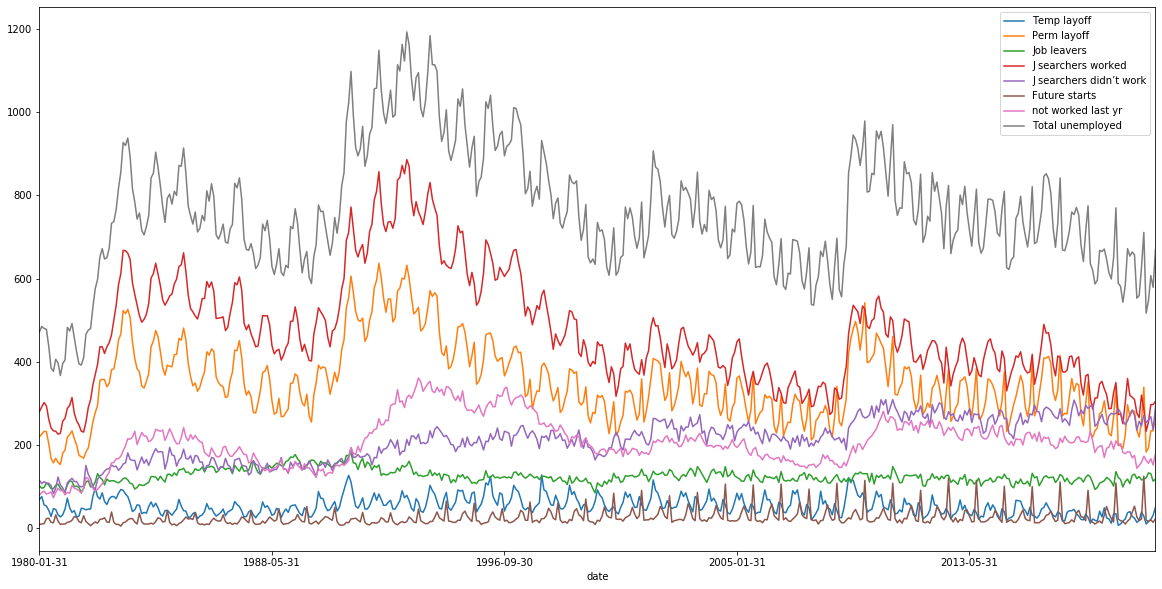

In [8]:
df.plot(x='date', y=['Temp layoff', 'Perm layoff', 'Job leavers','J searchers worked','J searchers didn’t work', 
                     'Future starts', 'not worked last yr', 'Total unemployed'], figsize=(20, 10))

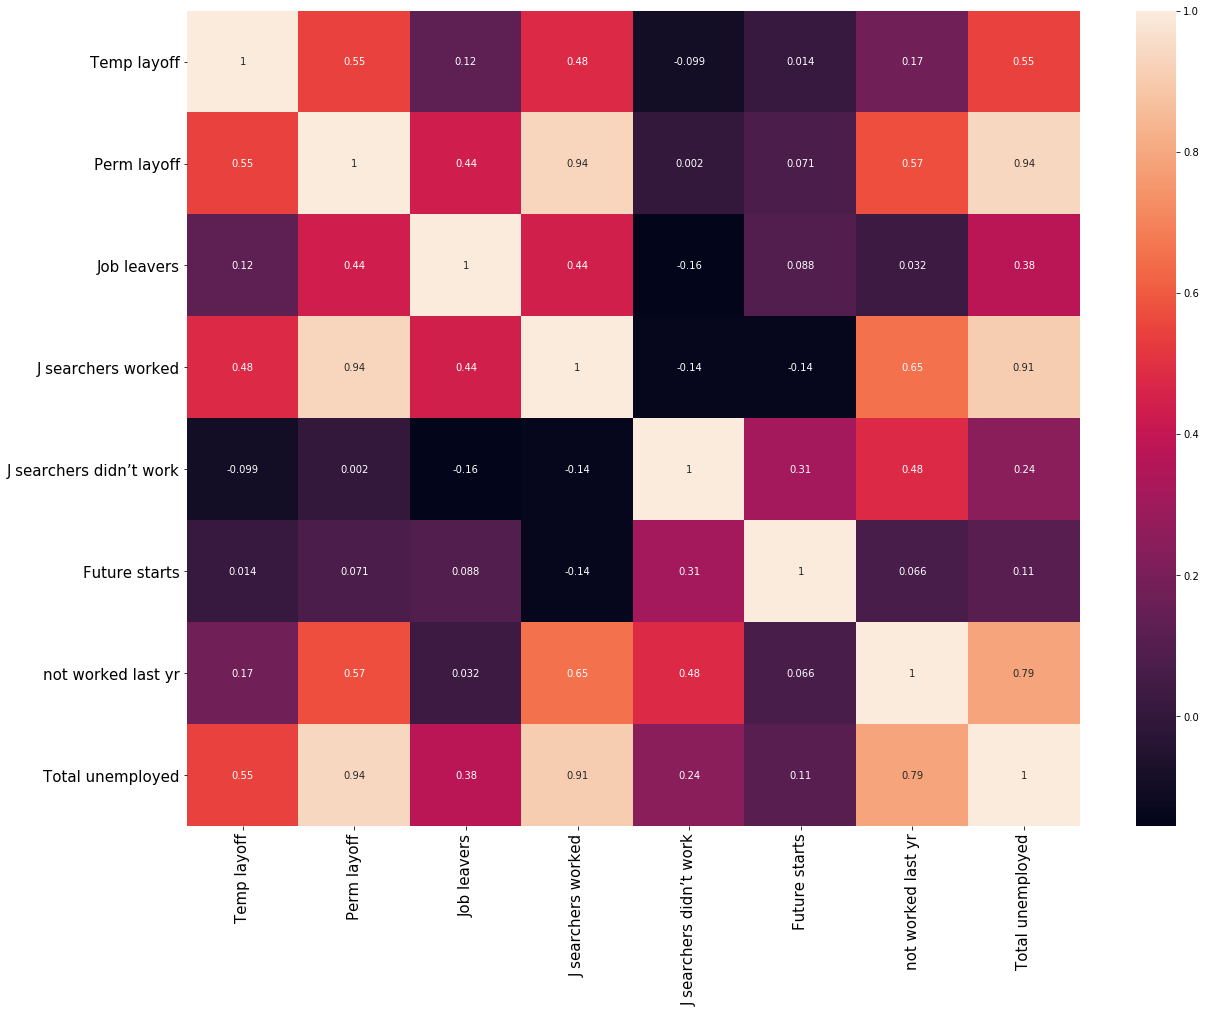

In [9]:
###CORRELATION ANALYSIS ###

corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':10})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

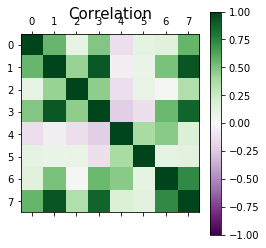

In [10]:
plt.matshow(df.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('Correlation', size=15)
plt.colorbar()
plt.show()

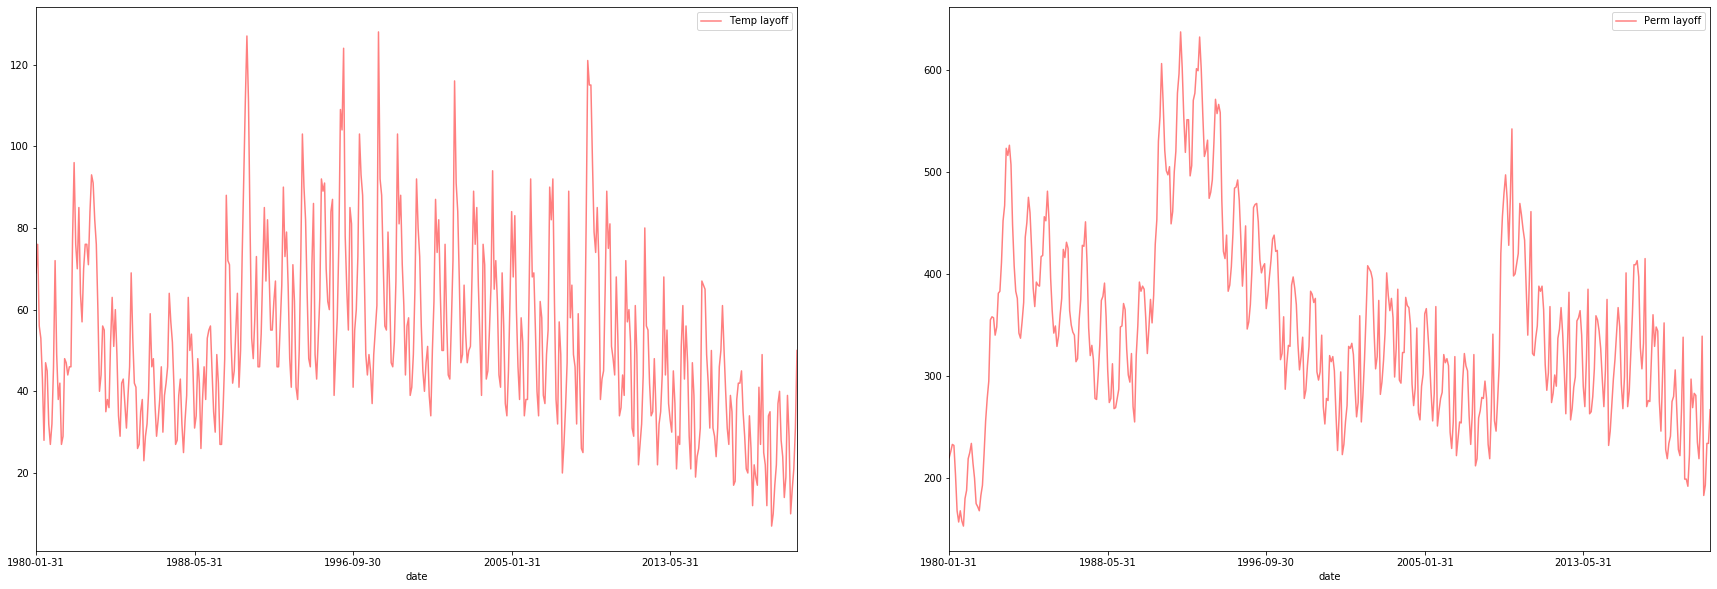

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))

for ycol, ax in zip(['Temp layoff', 'Perm layoff'], axes):

    df.plot(kind='line', x='date', y=ycol, ax=ax, alpha=0.5, color='r')

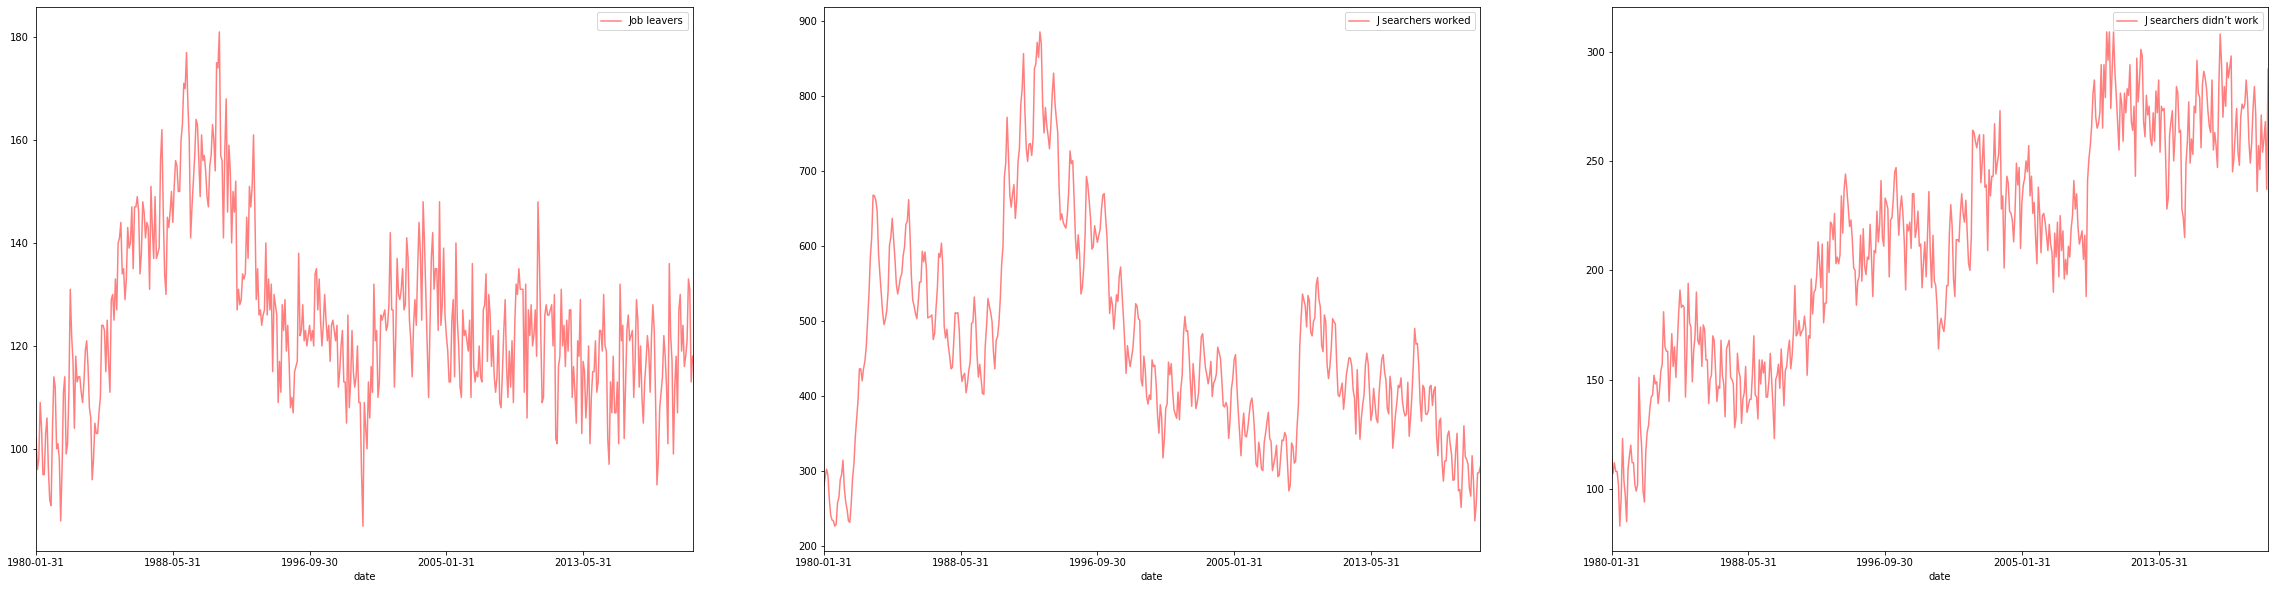

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(40,10))

for ycol, ax in zip(['Job leavers', 'J searchers worked','J searchers didn’t work'], axes):

    df.plot(kind='line', x='date', y=ycol, ax=ax, alpha=0.5, color='r')

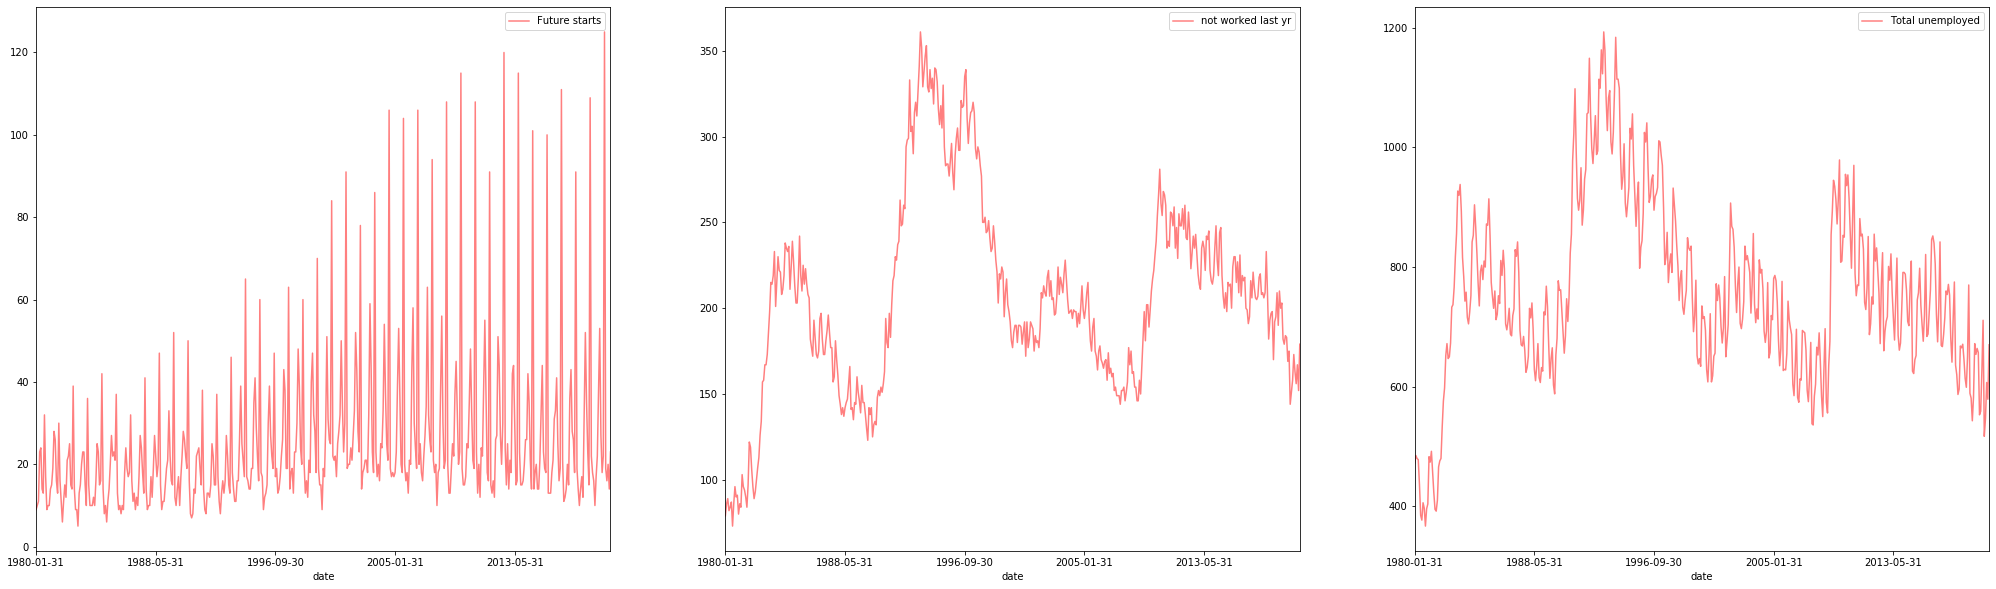

In [140]:
df = pd.read_csv('unemployment_data.csv') 

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(35,10))

for ycol, ax in zip(['Future starts','not worked last yr', 'Total unemployed'], axes):

    df.plot(kind='line', x='date', y=ycol, ax=ax, alpha=0.5, color='r')

count     481.000000
mean      758.482328
std       149.728435
min       367.000000
25%       666.000000
50%       744.000000
75%       844.000000
max      1193.000000
Name: Total unemployed, dtype: float64

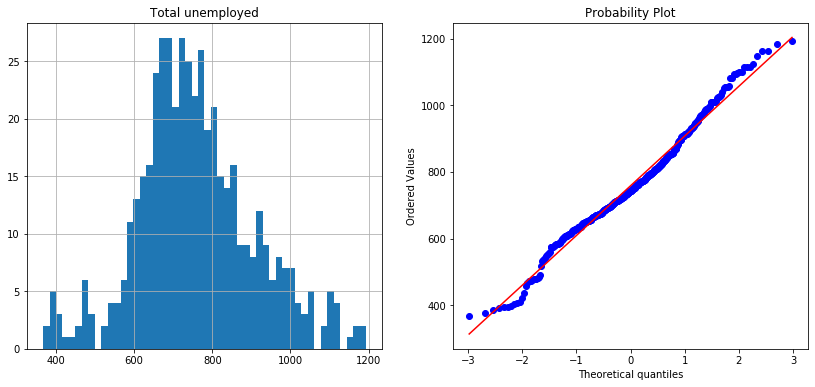

In [28]:
### CHECK FOR NORMALITY AND GAUSSIAN DISTRIBUTION OF THE DATA ###

from scipy import stats
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df["Total unemployed"].hist(bins=50)
plt.title('Total unemployed')
plt.subplot(1,2,2)
stats.probplot(df['Total unemployed'], plot=plt);
df["Total unemployed"].describe().T

In [29]:
from scipy import stats
    
stat,p = stats.normaltest(df["Temp layoff"])
print('Temp layoff Statistics=%.3f, p=%.3f' % (stat,p))
alpha = 0.05
if p > alpha:
    print('Temp layoff looks Gaussian (fail to reject H0)')
else:
    print('Temp layoff do not look Gaussian (reject H0)')
    
stat,p = stats.normaltest(df["Perm layoff"])
print('Perm layoff Statistics=%.3f, p=%.3f' % (stat,p))
alpha = 0.05
if p > alpha:
    print('Perm layoff looks Gaussian (fail to reject H0)')
else:
    print('Perm layoff do not look Gaussian (reject H0)')
    
stat,p = stats.normaltest(df["Job leavers"])
print('Job leavers Statistics=%.3f, p=%.3f' % (stat,p))
alpha = 0.05
if p > alpha:
    print('Job leavers looks Gaussian (fail to reject H0)')
else:
    print('Job leavers do not look Gaussian (reject H0)')
    
stat,p = stats.normaltest(df["J searchers worked"])
print('J searchers worked Statistics=%.3f, p=%.3f' % (stat,p))
alpha = 0.05
if p > alpha:
    print('J searchers worked looks Gaussian (fail to reject H0)')
else:
    print('J searchers worked do not look Gaussian (reject H0)')
    
stat,p = stats.normaltest(df["J searchers didn’t work"])
print('J searchers didn’t work Statistics=%.3f, p=%.3f' % (stat,p))
alpha = 0.05
if p > alpha:
    print('J searchers didn’t work looks Gaussian (fail to reject H0)')
else:
    print('J searchers didn’t work do not look Gaussian (reject H0)')
    
stat,p = stats.normaltest(df["Future starts"])
print('Future starts Statistics=%.3f, p=%.3f' % (stat,p))
alpha = 0.05
if p > alpha:
    print('Future starts looks Gaussian (fail to reject H0)')
else:
    print('Future starts do not look Gaussian (reject H0)')
    
stat,p = stats.normaltest(df["not worked last yr"])
print('not worked last yr Statistics=%.3f, p=%.3f' % (stat,p))
alpha = 0.05
if p > alpha:
    print('not worked last yr looks Gaussian (fail to reject H0)')
else:
    print('not worked last yr do not look Gaussian (reject H0)')

    
stat,p = stats.normaltest(df["Total unemployed"])
print('Total unemployed Statistics=%.3f, p=%.3f' % (stat,p))
alpha = 0.05
if p > alpha:
    print('Total unemployed looks Gaussian (fail to reject H0)')
else:
    print('Total unemployed do not look Gaussian (reject H0)')

Temp layoff Statistics=37.111, p=0.000
Temp layoff do not look Gaussian (reject H0)
Perm layoff Statistics=26.548, p=0.000
Perm layoff do not look Gaussian (reject H0)
Job leavers Statistics=28.826, p=0.000
Job leavers do not look Gaussian (reject H0)
J searchers worked Statistics=37.450, p=0.000
J searchers worked do not look Gaussian (reject H0)
J searchers didn’t work Statistics=39.359, p=0.000
J searchers didn’t work do not look Gaussian (reject H0)
Future starts Statistics=299.038, p=0.000
Future starts do not look Gaussian (reject H0)
not worked last yr Statistics=7.763, p=0.021
not worked last yr do not look Gaussian (reject H0)
Total unemployed Statistics=6.970, p=0.031
Total unemployed do not look Gaussian (reject H0)


# Step 4: Vector Autoregression model

In [30]:
### CHECKING FOR CAUSALITY USING GRANGER CAUSALITY TEST ###

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False, maxlag=5):    
    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. 

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df  

In [31]:
grangers_causation_matrix(df, variables = ['Temp layoff', 'Perm layoff', 'Job leavers','J searchers worked',
                                           'J searchers didn’t work', 'Future starts', 'not worked last yr', 
                                           'Total unemployed']) 

,Temp layoff_x,Perm layoff_x,Job leavers_x,J searchers worked_x,J searchers didn’t work_x,Future starts_x,not worked last yr_x,Total unemployed_x
Temp layoff_y,1.0,0.0501,0.0000,0.0,0.0000,0.0,0.0036,0.0003
Perm layoff_y,0.0,1.0000,0.0000,0.0,0.0000,0.0,0.0033,0.0189
Job leavers_y,0.0,0.0000,1.0000,0.0,0.0006,0.0,0.0113,0.0000
J searchers worked_y,0.0,0.0000,0.0000,1.0,0.0000,0.0,0.0000,0.0000
J searchers didn’t work_y,0.0,0.0000,0.0004,0.0,1.0000,0.0,0.7849,0.0000
Future starts_y,0.0,0.0000,0.0004,0.0,0.0000,1.0,0.0474,0.0000
not worked last yr_y,0.0,0.0000,0.0068,0.0,0.1428,0.0,1.0000,0.0000
Total unemployed_y,0.0,0.0430,0.0000,0.0,0.0000,0.0,0.0000,1.0000


In [32]:
### COINTEGRATION TEST USING JOHANSON'S COINTEGRATION TEST ###

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df [['Temp layoff', 'Perm layoff', 'Job leavers','J searchers worked',
                                           'J searchers didn’t work', 'Future starts', 'not worked last yr', 
                                           'Total unemployed']]) 

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Temp layoff ::  452.87    > 143.6691  =>   True
Perm layoff ::  235.64    > 111.7797  =>   True
Job leavers ::  126.58    > 83.9383   =>   True
J searchers worked ::  49.45     > 60.0627   =>   False
J searchers didn’t work ::  25.85     > 40.1749   =>   False
Future starts ::  10.16     > 24.2761   =>   False
not worked last yr ::  2.81      > 12.3212   =>   False
Total unemployed ::  0.02      > 4.1296    =>   False


In [3]:
### SPLIT TRAIN TEST ###

train_date = date[:int(len(df)*0.8)]
train = df[:int(len(df)*0.8)].copy()

test_date = date[int(len(df)*0.8):]
test = df[int(len(df)*0.8):].copy()

print(train.shape, test.shape)

(384, 8) (97, 8)


In [4]:
### PLOTTING UTILITY FUNCTIONS ###

def plot_sensor(name):
    
    plt.figure(figsize=(16,4))

    plt.plot(train_date, train[name], label='train')
    plt.plot(test_date, test[name], label='test')
    plt.ylabel(name); plt.legend()
    plt.show()
    
def plot_autocor(name, df):
    
    plt.figure(figsize=(16,4))
    
    # pd.plotting.autocorrelation_plot(df[name])
    # plt.title(name)
    # plt.show()
    
    timeLags = np.arange(1,100*24)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()

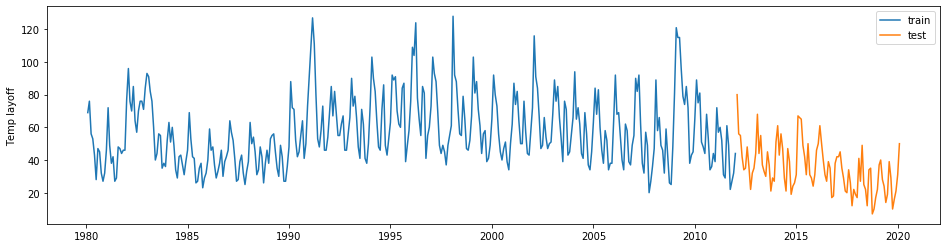

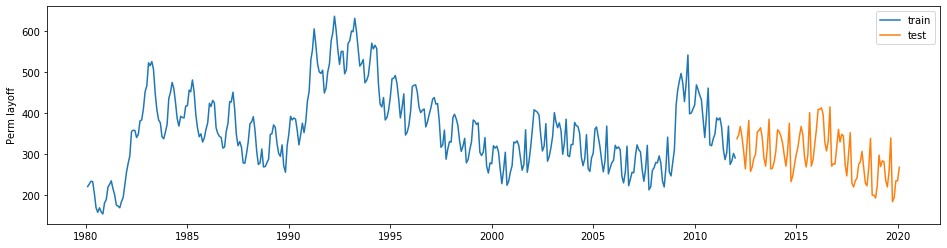

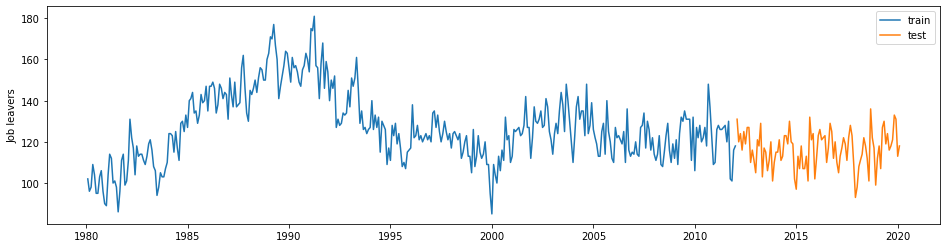

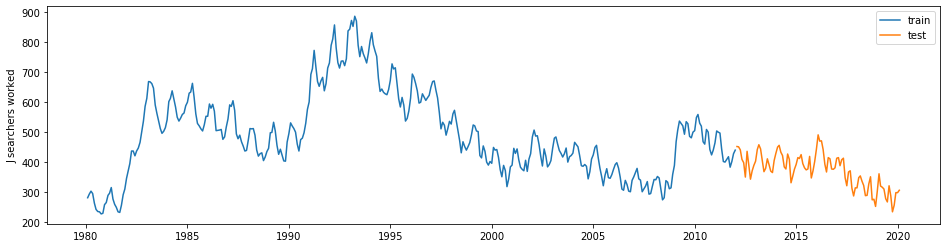

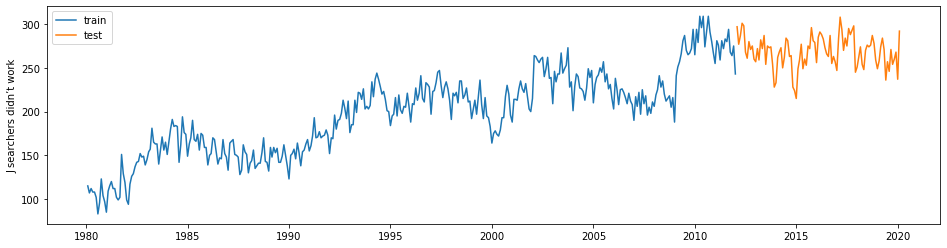

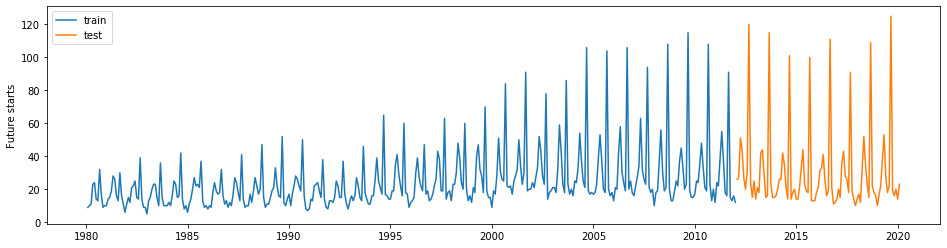

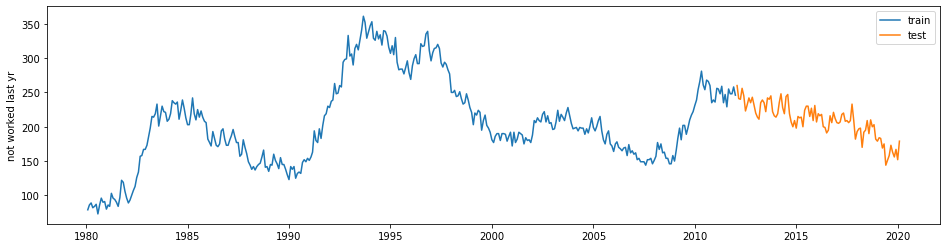

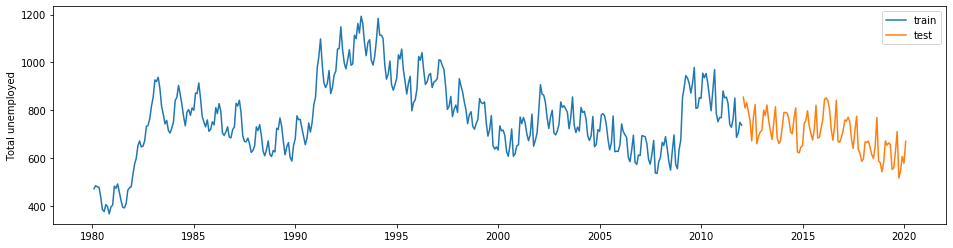

In [5]:
### PLOT ORIGINAL SERIES ###
for col in df.columns:
    plot_sensor(col)

C:\Users\minaa\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\minaa\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


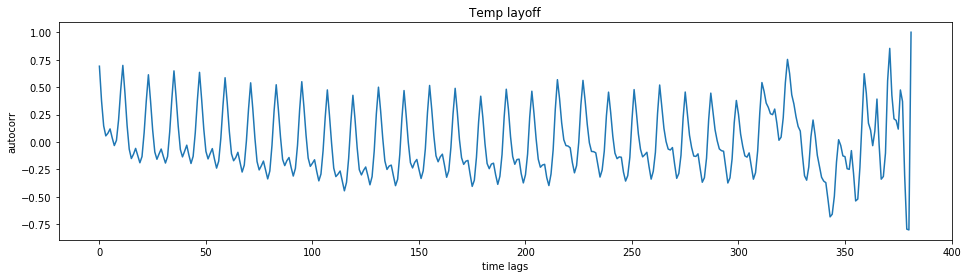

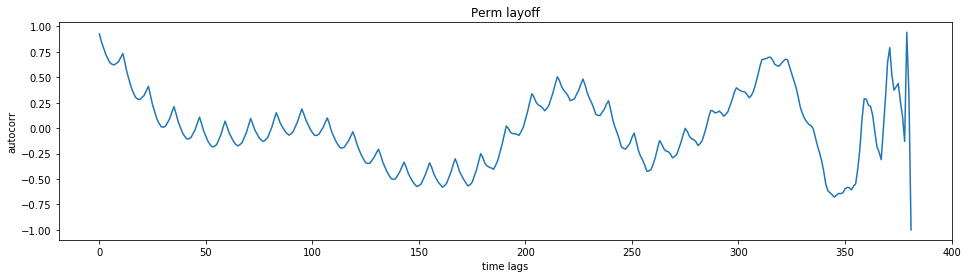

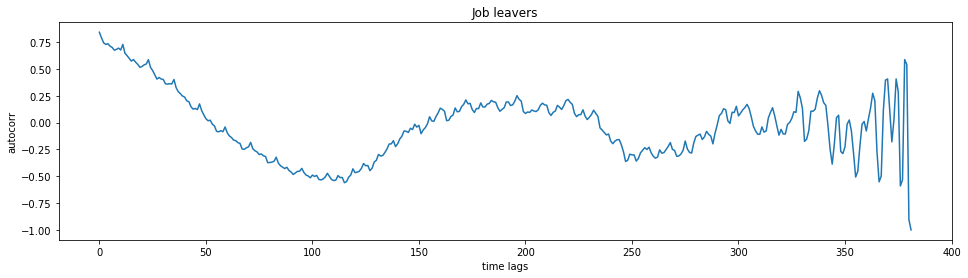

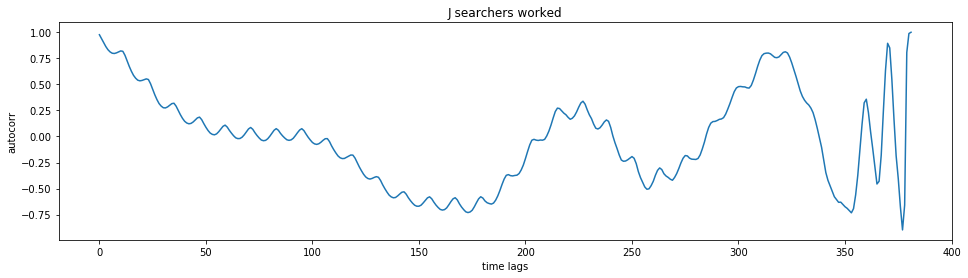

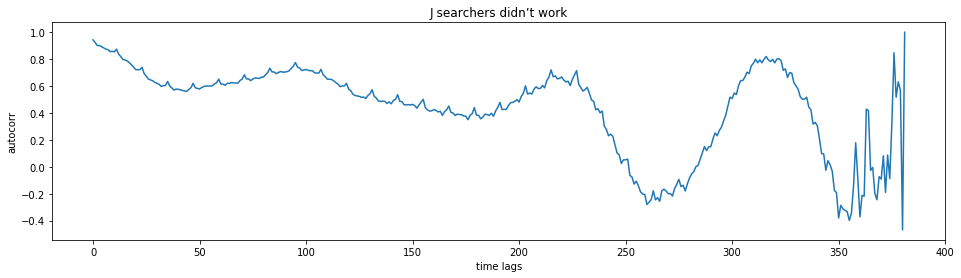

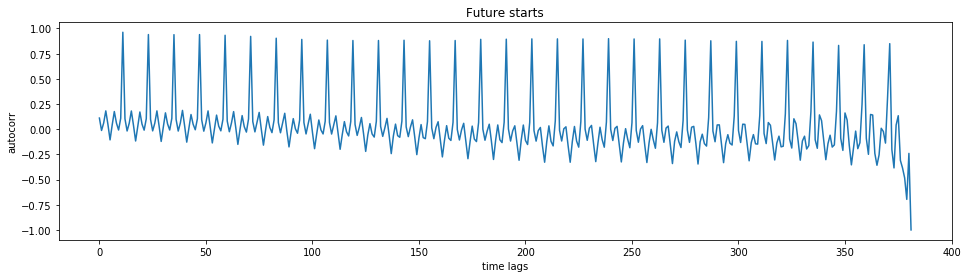

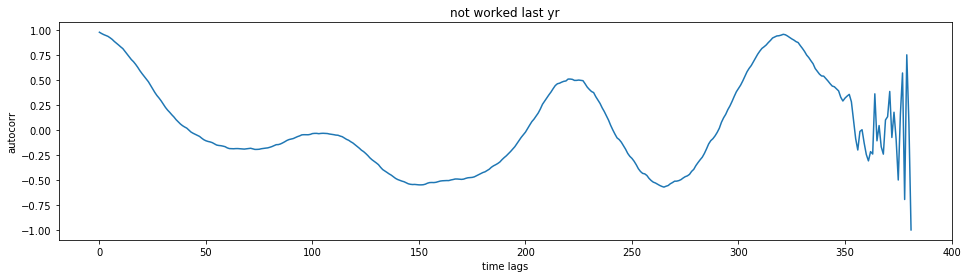

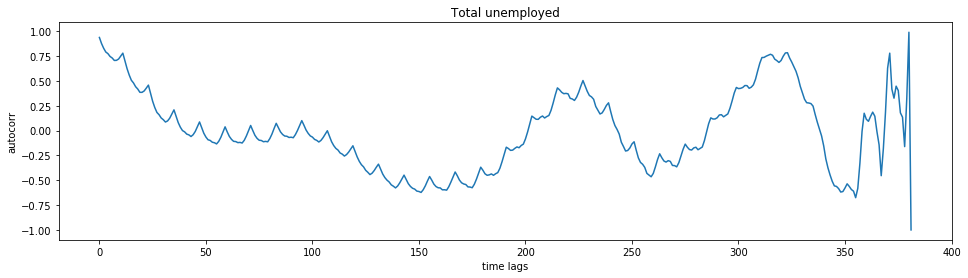

In [6]:
### PLOT AUTOCORRELATION ###

for col in df.columns:
    plot_autocor(col, train)

In [8]:
### OPERATE DIFFERENTIATION ###

period = 12

df_diff = df.diff(period).dropna()

In [9]:
### SPLIT DIFFERENTIAL DATA IN TRAIN AND TEST ###

train_diff = df_diff.iloc[:len(train)-period,:].copy()
test_diff = df_diff.iloc[len(train)-period:,:].copy()

train_init = df.iloc[:len(train)-period,:].copy()
test_init = df.iloc[len(train)-period:-period,:].copy()

print(train_diff.shape, train_init.shape)
print(test_diff.shape, test_init.shape)

(372, 8) (372, 8)
(97, 8) (97, 8)


In [13]:
### CHECK FOR STATIONARITY USING AUGMENTED DICKEY-FULLER (ADF) METHOD ###

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [14]:
### ADF TEST ON EACH COLUMN ###

for name, column in train_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Temp layoff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.368
 No. Lags Chosen       = 12
 Critical value 1%     = -3.449
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Perm layoff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.313
 No. Lags Chosen       = 17
 Critical value 1%     = -3.449
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0004. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Job leavers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signifi

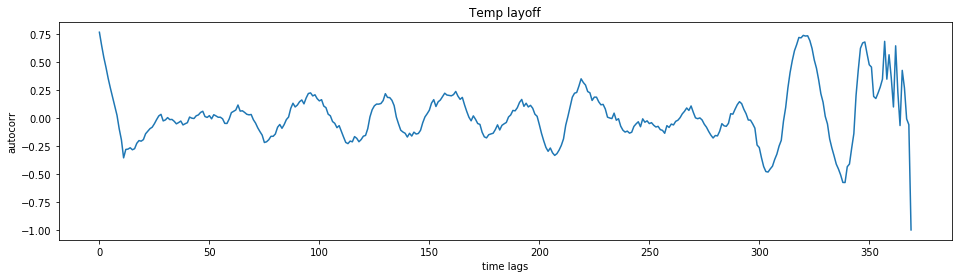

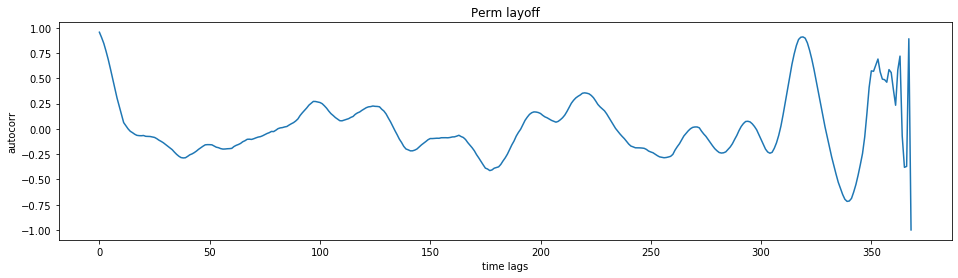

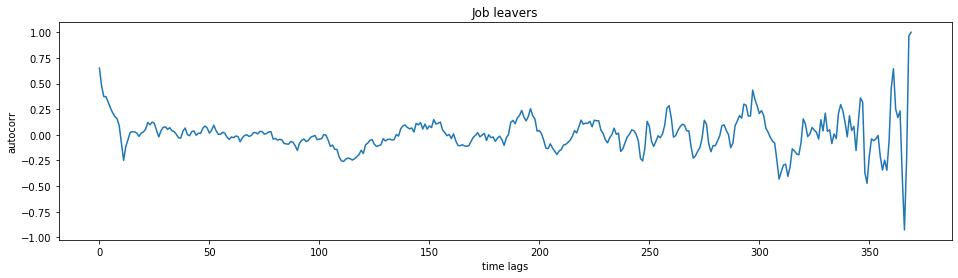

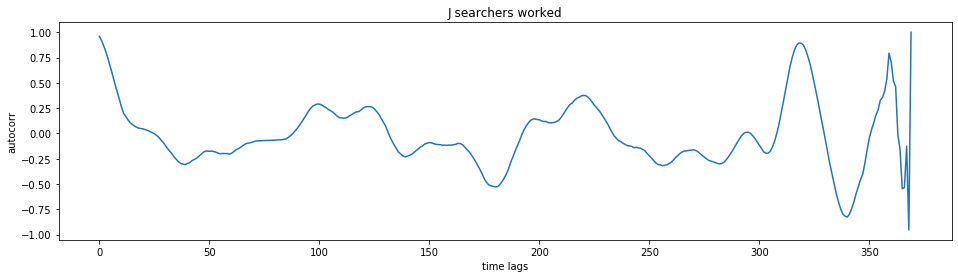

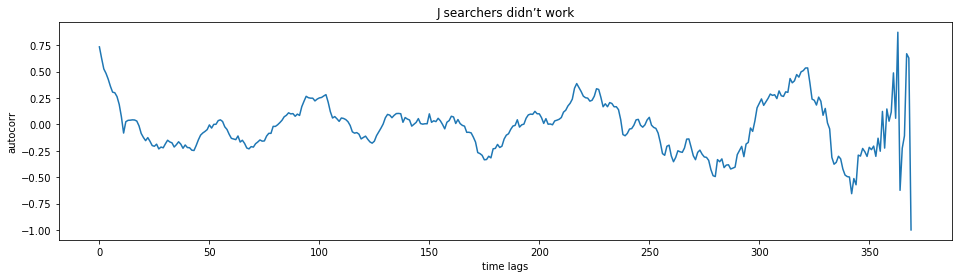

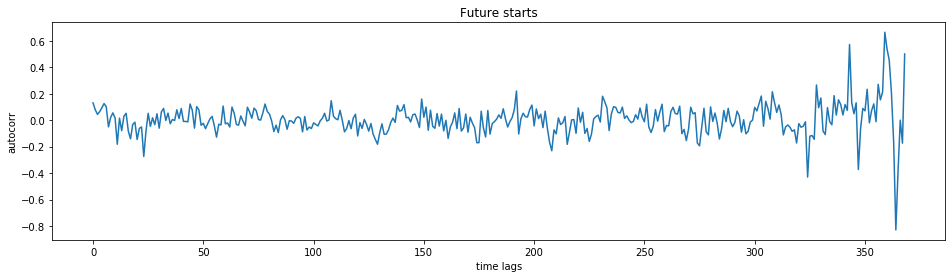

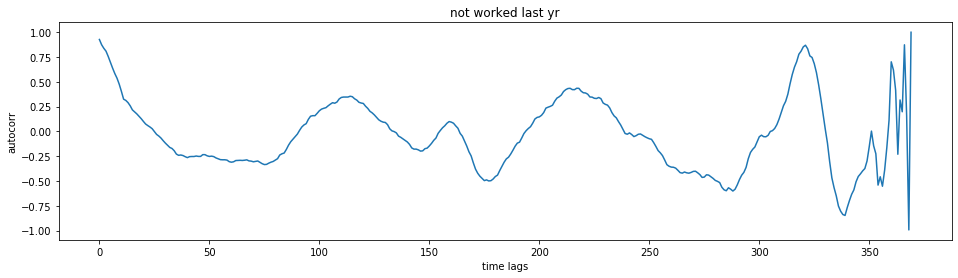

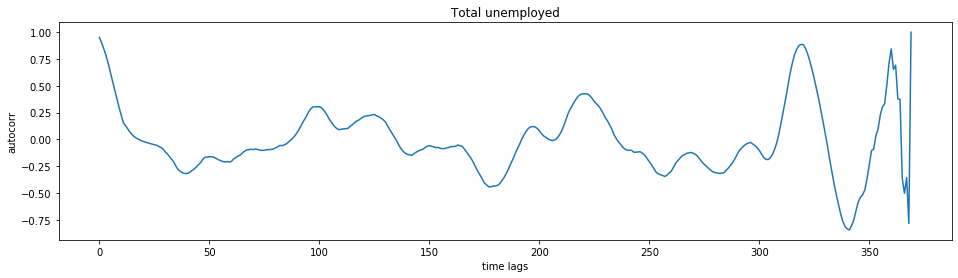

In [15]:
### PLOT DIFFERENTIAL SERIES ###

for col in df.columns:
    plot_autocor(col, train_diff)

In [16]:
### FIND BEST VAR ORDER ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,10):
    model = VAR(endog=train_diff.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER 2 BEST AIC: 31.474766986611122


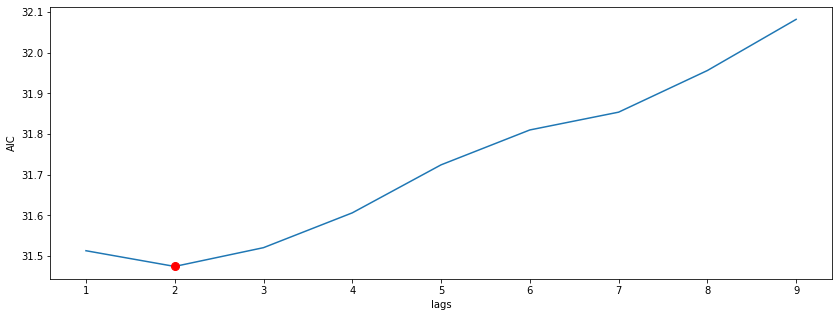

In [17]:
### PLOT AICs ### 

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(len(AIC)), range(1,50))
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [50]:
## FIT FINAL VAR WITH LAG CORRESPONTING TO THE BEST AIC ###

var = VAR(endog=train_diff.values)
var_result = var.fit(maxlags=best_order)
var_result.aic

31.474766986611122

In [21]:
var_result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 07, Apr, 2020
Time:                     17:30:33
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    32.9132
Nobs:                     370.000    HQIC:                   32.0461
Log likelihood:          -9886.89    FPE:                4.67243e+13
AIC:                      31.4748    Det(Omega_mle):     3.26188e+13
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.191288         0.536616            0.356           0.721
L1.y1        -1.353139         0.596016           -2.270           0.023
L1.y2         0.123537         0.099414            1.243           0.214
L1.y3        -0.006678

In [23]:
### CHECK FOR SERIAL CORRELATION OF RESIDUALS (ERRORS) USING DURBIN WATSON STATISTIC ###

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(var_result.resid)

for col, val in zip(df[['Temp layoff', 'Perm layoff', 'Job leavers','J searchers worked',
                                           'J searchers didn’t work', 'Future starts', 'not worked last yr', 
                                           'Total unemployed']], out):
    print((col), ':', round(val, 2))

Temp layoff : 2.1
Perm layoff : 1.98
Job leavers : 2.01
J searchers worked : 1.97
J searchers didn’t work : 2.0
Future starts : 2.03
not worked last yr : 2.03
Total unemployed : 1.98


In [51]:
### UTILITY FUNCTION FOR RETRIVE VAR PREDICTIONS ###

def retrive_prediction(prior, prior_init, steps):
    
    pred = var_result.forecast(np.asarray(prior), steps=steps)
    init = prior_init.tail(period).values
    
    if steps > period:
        id_period = list(range(period))*(steps//period)
        id_period = id_period + list(range(steps-len(id_period)))
    else:
        id_period = list(range(steps))
    
    final_pred = np.zeros((steps, prior.shape[1]))
    for j, (i,p) in enumerate(zip(id_period, pred)):
        final_pred[j] = init[i]+p
        init[i] = init[i]+p    
        
    return final_pred

In [52]:
### RETRIVE PREDICTION AND OBTAIN THE CORRESPONDING ACTUAL VALUES ###

date = '2017-01-31'
forward = 36
date_range = pd.date_range(date, periods = forward+1, freq='M', closed='right')

final_pred = retrive_prediction(df_diff.loc[:date], df.loc[:date], steps = forward)
final_true = df.loc[date_range]

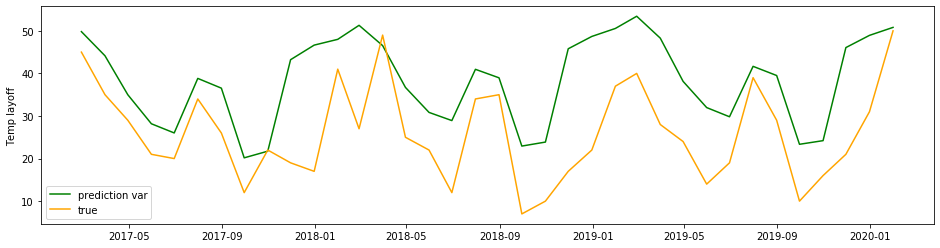

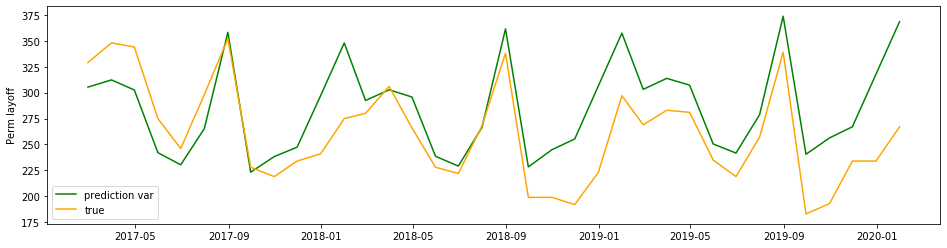

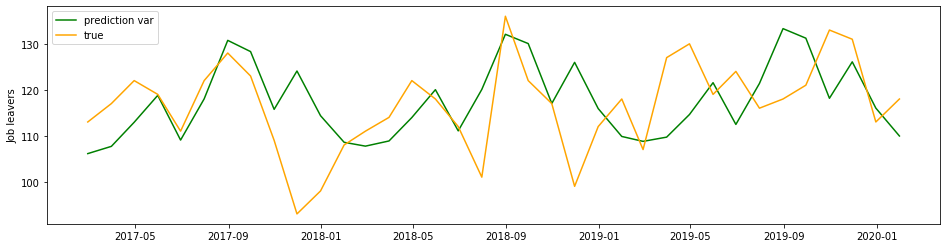

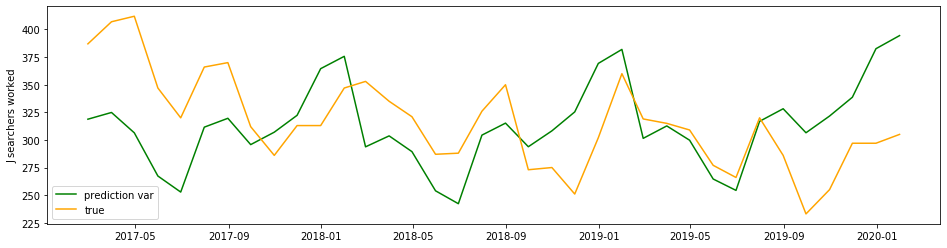

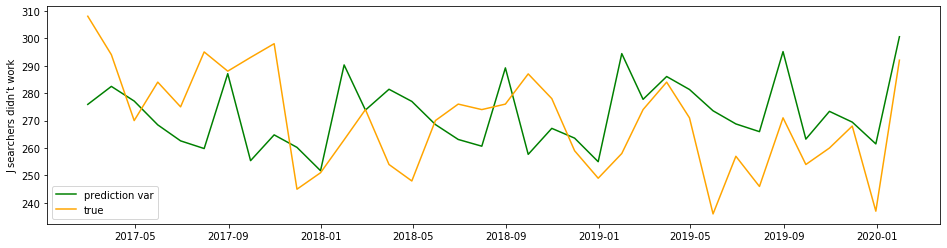

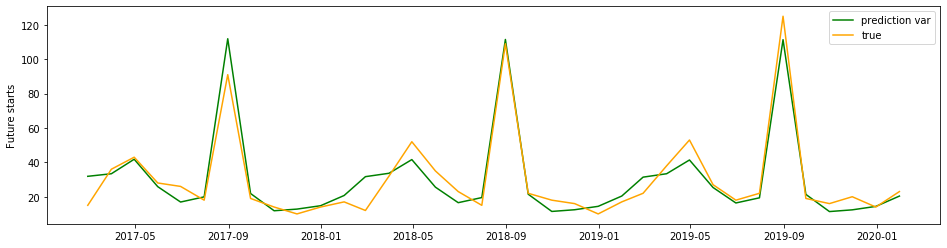

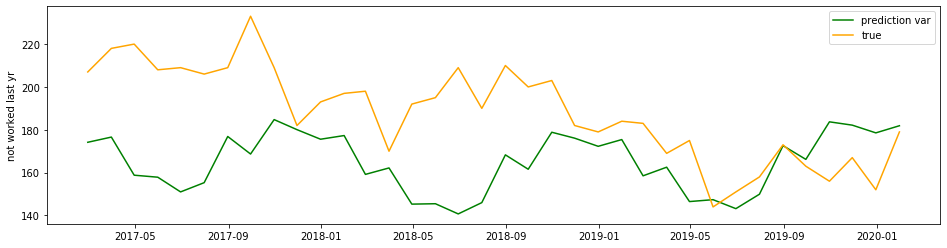

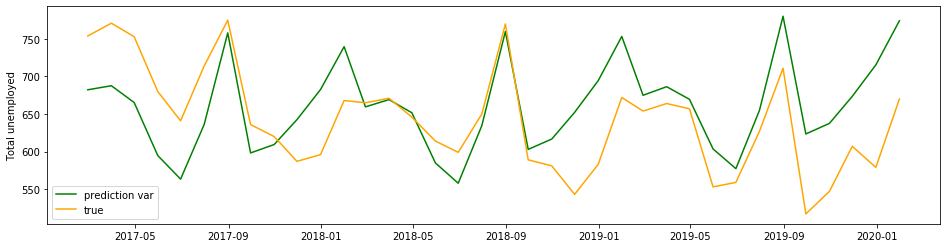

In [55]:
### PLOT ACTUAL vs PREDICTION ###

for i,col in enumerate(df.columns):

    plt.figure(figsize=(16,4))
    plt.plot(date_range, final_pred[:,i], c='green', label='prediction var')
    plt.plot(date_range, final_true[col].values, c='orange', label='true')
    plt.ylabel(col); plt.legend()
    plt.show()

In [54]:
#ACCURACY METRICS

from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

accuracy_prod = forecast_accuracy(final_pred[:,i], final_true[col].values)

for k, v in accuracy_prod.items():
    print((k), ': ',round(v,4))

mape :  0.0865
me :  17.9326
mae :  54.1468
mpe :  0.0345
rmse :  65.6341
corr :  0.5082
minmax :  0.0789


# Step 5: Combine VAR & LSTM

In [102]:
### UTILITY FUNCTIONS FOR NEURAL NETWORK TRAINING ###

def autocor_pred(real, pred, lag=1):
    return pearsonr(real[:-lag], pred[lag:])[0]


seq_length = 12

def get_model():
    
    opt = RMSprop(lr=0.002)
    
    inp = Input(shape=(seq_length, 8))
    
    x = LSTM(100)(inp)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    out = Dense(8)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=opt, loss='mse', metrics=['mse', 'mae', 'mape'])
    
    return model

In [103]:
### GET TRAIN VALIDATION AND TEST DATA FOR NEURAL NETWORK ###

X = var_result.fittedvalues

y_train = train.iloc[period+best_order:].values
y_train_var = X + train_init.iloc[best_order:].values
X_train = np.concatenate([train_diff.iloc[best_order:].values], axis=1)
X_train_var = np.concatenate([X], axis=1)

y_val = y_train[int(len(X)*0.8):]
y_val_var = y_train_var[int(len(X)*0.8):]
X_val = X_train[int(len(X)*0.8):]
X_val_var = X_train_var[int(len(X)*0.8):]

y_train = y_train[:int(len(X)*0.8)]
y_train_var = y_train_var[:int(len(X)*0.8)]
X_train = X_train[:int(len(X)*0.8)]
X_train_var = X_train_var[:int(len(X)*0.8)]

y_test = test.values
X_test = np.concatenate([test_diff.values], axis=1)

In [104]:
### SCALE DATA ###

scaler_y = StandardScaler()
scaler = StandardScaler()

y_train = scaler_y.fit_transform(y_train)
y_train_var = scaler_y.transform(y_train_var)
y_val = scaler_y.transform(y_val)
y_val_var = scaler_y.transform(y_val_var)
y_test = scaler_y.transform(y_test)

X_train = scaler.fit_transform(X_train)
X_train_var = scaler.transform(X_train_var)
X_val = scaler.transform(X_val)
X_val_var = scaler.transform(X_val_var)
X_test = scaler.transform(X_test)

In [105]:
### BUILD DATA GENERATOR ###

generator_train = TimeseriesGenerator(X_train, y_train, length=seq_length, batch_size=100)
generator_train_var = TimeseriesGenerator(X_train_var, y_train_var, length=seq_length, batch_size=100)
generator_val = TimeseriesGenerator(X_val, y_val, length=seq_length, batch_size=100)
generator_val_var = TimeseriesGenerator(X_val_var, y_val_var, length=seq_length, batch_size=100)
generator_test = TimeseriesGenerator(X_test, y_test, length=seq_length, batch_size=100)

In [106]:
### FIT NEURAL NETWORK WITH VAR FITTED VALUES AND RAW DATA ###

tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

print('--------', 'train model with VAR fitted values', '--------')
model_var = get_model()
model_var.fit_generator(generator_train_var, steps_per_epoch= len(generator_train_var),
                        epochs=300, validation_data=generator_val_var, validation_steps = len(generator_val_var), 
                        callbacks=[es], verbose = 1)


print('--------', 'train model with raw data', '--------')
model_var.fit_generator(generator_train, steps_per_epoch= len(generator_train),
                        epochs=300, validation_data=generator_val, validation_steps = len(generator_val), 
                        callbacks=[es], verbose = 1)

-------- train model with VAR fitted values --------
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 3 steps, validate for 1 steps
Epoch 1/300
3/3 [==============================] - 4s 1s/step - loss: 0.9759 - mse: 0.9811 - mae: 0.7806 - mape: 194.2415 - val_loss: 1.4044 - val_mse: 1.4044 - val_mae: 0.8830 - val_mape: 138.1807
Epoch 2/300
3/3 [==============================] - 0s 35ms/step - loss: 0.9060 - mse: 0.9089 - mae: 0.7500 - mape: 204.1008 - val_loss: 1.3987 - val_mse: 1.3987 - val_mae: 0.8846 - val_mape: 144.7132
Epoch 3/300
3/3 [==============================] - 0s 33ms/step - loss: 0.8852 - mse: 0.8879 - mae: 0.7400 - mape: 173.1706 - val_loss: 1.4236 - val_mse: 1.4236 - val_mae: 0.8907 - val_mape: 160.9140
Epoch 4/300
3/3 [==============================] - 0s 33ms/step - loss: 0.8569 - mse: 0.8596 - mae: 0.7328 - mape: 203.1912 - val_loss: 1.3776 - val_mse: 1.3776 - val_mae: 0.8777 - val_mape: 149.1061
Epoch 5/300
3/3 [==============================] - 0s 31ms/

In [128]:
### OBTAIN PREDICTIONS AND RETRIVE ORIGINAL DATA ###

true = scaler_y.inverse_transform(y_test[seq_length:])

pred = model_var.predict_generator(generator_test)
pred = scaler_y.inverse_transform(pred)

In [129]:
### FIT NEURAL NETWORK WITH ONLY ORIGINAL DATA ###

tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

simple_model = get_model()
simple_model.fit_generator(generator_train, steps_per_epoch= len(generator_train),
                            epochs=300, validation_data=generator_val, validation_steps = len(generator_val), 
                            callbacks=[es], verbose = 1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 3 steps, validate for 1 steps
Epoch 1/300
3/3 [==============================] - 4s 1s/step - loss: 0.9957 - mse: 0.9997 - mae: 0.7854 - mape: 237.7210 - val_loss: 1.3899 - val_mse: 1.3899 - val_mae: 0.8768 - val_mape: 182.5004
Epoch 2/300
3/3 [==============================] - 0s 33ms/step - loss: 0.9087 - mse: 0.9112 - mae: 0.7484 - mape: 207.6601 - val_loss: 1.3750 - val_mse: 1.3750 - val_mae: 0.8744 - val_mape: 180.7153
Epoch 3/300
3/3 [==============================] - 0s 34ms/step - loss: 0.8805 - mse: 0.8824 - mae: 0.7362 - mape: 180.3323 - val_loss: 1.3895 - val_mse: 1.3895 - val_mae: 0.8765 - val_mape: 215.1326
Epoch 4/300
3/3 [==============================] - 0s 32ms/step - loss: 0.8530 - mse: 0.8547 - mae: 0.7303 - mape: 213.2251 - val_loss: 1.3416 - val_mse: 1.3416 - val_mae: 0.8661 - val_mape: 181.5597
Epoch 5/300
3/3 [==============================] - 0s 32ms/step - loss: 0.8452 - mse: 0.8457 - mae: 0.7252 - map

In [130]:
### OBTAIN PREDICTIONS ###

pred_simple = simple_model.predict_generator(generator_test)
pred_simple = scaler_y.inverse_transform(pred_simple)

In [110]:
### COMPUTE METRICS ON TEST DATA ###

diz_error_lstm, diz_ac_lstm = {}, {}
diz_error_var_lstm, diz_ac_var_lstm = {}, {}
diz_mse_lstm, diz_mse_var_lstm = {}, {} 

for i,col in enumerate(df.columns):
    
    mse = mean_squared_error(true[:,i], pred_simple[:,i])
    diz_mse_lstm[col] = mse
    
    mse = mean_squared_error(true[:,i], pred[:,i])
    diz_mse_var_lstm[col] = mse
    
    error = mean_absolute_error(true[:,i], pred_simple[:,i])
    diz_error_lstm[col] = error
    
    error = mean_absolute_error(true[:,i], pred[:,i])
    diz_error_var_lstm[col] = error
    
    ac = autocor_pred(true[:,i], pred_simple[:,i])
    diz_ac_lstm[col] = ac
    
    ac = autocor_pred(true[:,i], pred[:,i])
    diz_ac_var_lstm[col] = ac

In [123]:
from math import sqrt
rmse = sqrt(mean_squared_error(true, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 77.196


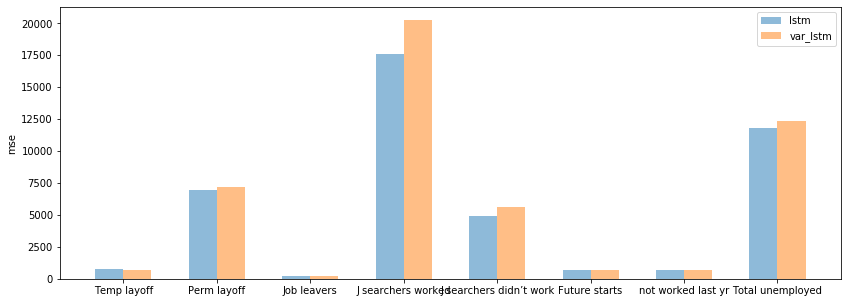

In [111]:
plt.figure(figsize=(14,5))
plt.bar(np.arange(len(diz_mse_lstm))-0.15, diz_mse_lstm.values(), alpha=0.5, width=0.3, label='lstm')
plt.bar(np.arange(len(diz_mse_var_lstm))+0.15, diz_mse_var_lstm.values(), alpha=0.5, width=0.3, label='var_lstm')
plt.xticks(range(len(diz_mse_lstm)), diz_mse_lstm.keys())
plt.ylabel('mse'); plt.legend()
np.set_printoptions(False)

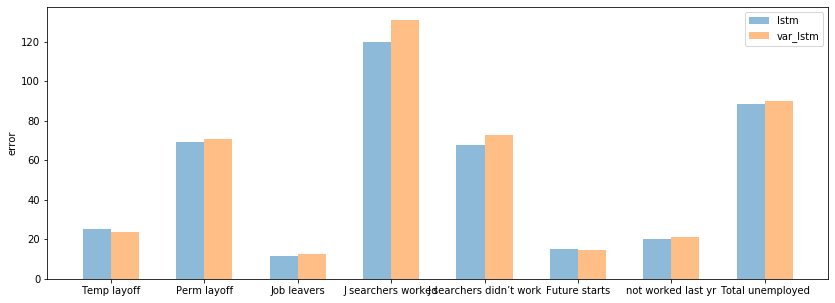

In [112]:
plt.figure(figsize=(14,5))
plt.bar(np.arange(len(diz_error_lstm))-0.15, diz_error_lstm.values(), alpha=0.5, width=0.3, label='lstm')
plt.bar(np.arange(len(diz_error_var_lstm))+0.15, diz_error_var_lstm.values(), alpha=0.5, width=0.3, label='var_lstm')
plt.xticks(range(len(diz_error_lstm)), diz_error_lstm.keys())
plt.ylabel('error'); plt.legend()
np.set_printoptions(False)

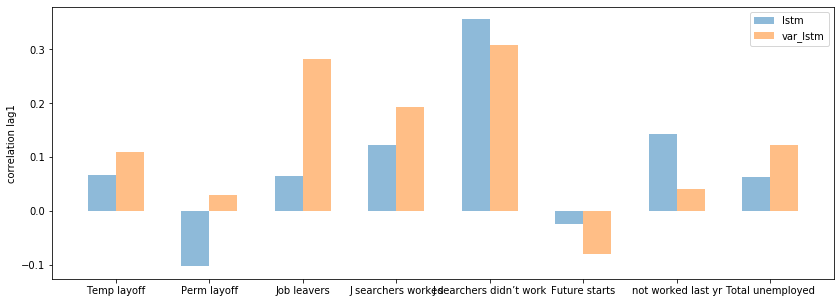

In [113]:
plt.figure(figsize=(14,5))
plt.bar(np.arange(len(diz_ac_lstm))-0.15, diz_ac_lstm.values(), alpha=0.5, width=0.3, label='lstm')
plt.bar(np.arange(len(diz_ac_var_lstm))+0.15, diz_ac_var_lstm.values(), alpha=0.5, width=0.3, label='var_lstm')
plt.xticks(range(len(diz_ac_lstm)), diz_ac_lstm.keys())
plt.ylabel('correlation lag1'); plt.legend()
np.set_printoptions(False)